### Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

### Load datasets

In [2]:
def load_data():
    
    train_data = h5py.File("datasets/train.h5", "r") # read h5py file
    train_x = np.array(train_data["train_set_x"][:]) # extract training examples
    train_y = np.array(train_data["train_set_y"][:]) # extract training labels
    
    test_data = h5py.File("datasets/test.h5", "r") # read h5py file
    test_x = np.array(test_data["test_set_x"][:])
    test_y = np.array(test_data["test_set_y"][:])
    
    classes = np.array(test_data["list_classes"][:]) # test_data classes ["cat", "not-cat"]
    
    train_y = train_y.reshape((1, train_y.shape[0])) # reshape into vector
    test_y = test_y.reshape((1, test_y.shape[0])) # reshape into vector
    
    return train_x, train_y, test_x, test_y, classes

In [3]:
# load data
train_x_orig , train_y_orig , test_x_orig , test_y_orig, classes = load_data()

# reshape training and test examples
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

In [4]:
def initialization_parameters(layer_dims):
    
    # layer_dims is vector of size (n,1)
    
    parameters = {} # store weights and bias
    
    np.random.seed(1)
    L = len(layer_dims)
    
    for l in range(1,L):    
        parameters["W" + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters["b" + str(l)] = np.zeros((layer_dims[l],1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters

In [5]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

In [6]:
def d_sigmoid(z):
    d_sig = (1 + np.exp(-z)) ** -1
    return d_sig

In [7]:
def relu(z):   
    A = np.maximum(0,z)
    cache = z
    return A, cache

In [8]:
def relu_backward(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [9]:
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ

In [10]:
def linear_forward(A, W, b):
    Z = W.dot(A) + b
    cache = (A, W, b)
    assert(Z.shape == (W.shape[0], A.shape[1]))
    return Z, cache

In [11]:
def linear_forward_activation(A_prev, W,  b, activation):
    
    if activation == "relu" or activation == "RELU":
        z, cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(z)
        
    elif activation == "sigmoid":
        z, cache = linear_forward(A_prev, W, b)
        A,activation_cache = sigmoid(z)
        
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache_ = (cache, activation_cache)
    
    return A, cache_

In [12]:
def forward_layer(X, parameters):
    
    caches = [] # keep track of cost
    A = X
    L = len(parameters)//2

    for l in range(1,L):
        
        A_prev = A # output of previous layer
        A, cache = linear_forward_activation(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation="relu")
        caches.append(cache)
        
    AL, cache = linear_forward_activation(A, parameters["W" + str(L)], parameters["b" + str(L)],activation="sigmoid")
    caches.append(cache)
    
    #print(AL.shape)
    #print(X.shape[1])
    assert(AL.shape == (1,X.shape[1]))
    
    return AL,caches

In [22]:
def compute_cost(AL, Y, parameters, lambd):
    
    m = Y.shape[1]
    L = len(parameters)//2
    parameters_sum = 0
    
    for l in range(0,L):
        parameters_sum += np.sum(np.square(parameters["W" + str(l+1)]))
        
    L2 = lambd * parameters_sum / (2*m)
    
    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost + L2
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [14]:
def relu_backward(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [47]:
def linear_backward(dZ, cache, lambd):
    
    A_prev, W, b = cache
    
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T) + (lambd * W) / m
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev,dW, db, 

In [48]:
def linear_backward_activation(dA, cache, activation, lambd = 0.7):
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache, lambd)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache, lambd)
        
    return dA_prev, dW, db

In [49]:
## let's do backward propogation
def backward_layer(AL, Y, cache, lambd):
    
    grads = {} # store derivatives of weights
    L = len(cache) # number of layers
    m = AL.shape[1] # number of training examples
    Y = Y.reshape(AL.shape) 
    
    # initialize dervative 
    dAL = -(np.divide(Y,AL) - np.divide(1-Y,1-AL))
    
    current_cache = cache[L-1]
    
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_backward_activation(dAL, current_cache,
                                                                                             activation = "sigmoid",
                                                                                            lambd = 0.7)
    
    for l in reversed(range(L-1)):
        current_cache = cache[l]
        dA_prev_temp, dW_temp, db_temp = linear_backward_activation(grads["dA" + str(l + 1)], 
                                                                    current_cache, activation = "relu",
                                                                    lambd = 0.7)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        
    return grads

In [50]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2

    for l in range(0,L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [51]:
def predict(X,Y, parameters):
    
    m = X.shape[1]
    n = len(parameters)
    p = np.zeros((1,m))
    
    probs, cache = forward_layer(X, parameters)
    
    for i in range(0,probs.shape[1]):
        
        if(probs[0][i] > 0.5):
            p[0][i] = 1
        else:
            p[0][i] = 0
            
    print("Accuracy  = " + str(np.sum(((p == Y)/m))))
    
    return p

In [61]:
def model(X, Y, layer_dims, learning_rate=0.0075, lambd=0.7, epochs=3000, print_cost=False):
    
    np.random.seed(1)
    costs = []
    
    # parameter initialization
    parameters = initialization_parameters(layer_dims)

    for i in range(1,epochs):

        AL, caches = forward_layer(X,parameters)
        
        cost = compute_cost(AL,Y,parameters,lambd)
        
        grads = backward_layer(AL, Y, caches, lambd)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 100 == 0 or i == epochs - 1:
            print("cost after iteration {} {} ".format(i, np.squeeze(cost)))
        if i % 100 or i == epochs:
            costs.append(cost)
       
    return parameters , cost

In [ ]:
layers_dims =  [12288, 20, 7, 5, 1] #  4-layer model
parameters, cost = model(train_x,train_y_orig, layers_dims, learning_rate=0.01, epochs=2500, print_cost=True)

cost after iteration 100 0.6695026113374584 
cost after iteration 200 0.6403315385185439 
cost after iteration 300 0.5920921702059441 
cost after iteration 400 0.5579700798222897 


In [59]:
p = predict(train_x,train_y_orig,parameters)

Accuracy  = 0.9999999999999998


In [60]:
pred_test = predict(test_x, test_y_orig, parameters)

Accuracy  = 0.74


Accuracy  = 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


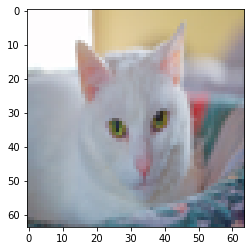

In [57]:
from PIL import Image
## START CODE HERE ##
my_image = "my_image.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##
num_px= 64
fname = "" + my_image
image = np.array(Image.open(fname).resize((64,64)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)


print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")